In [1]:
%cd stylegan2-ada-pytorch

/media/nikov/M2/Study/ITMO/GAN/myWork/Lab_5/stylegan2-ada-pytorch


In [2]:
# imports
import PIL
import os
import numpy as np
import torch
import lpips
import torch.nn as nn
import torchvision.transforms as transforms
from pytorch_msssim import ms_ssim
from stylegan2_models.arcface_model import get_model
from stylegan2_models.e4e.model_utils import load_e4e_standalone
from stylegan2_models.image_aligner.face_alignment import image_align
from stylegan2_models.image_aligner.landmarks_detector import LandmarksDetector
import torch.nn.functional as F
import torchvision.transforms as transforms
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display, FileLink
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import torch
from tqdm import tqdm


In [3]:
image2e4etensor = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])



def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(), 
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor

def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:   
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)

def truncation(latent1, latent2, psi=0.5):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    # indeces = [5,6,7,8,9,10,11,12]
    indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    return latent1


class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')


    def forward(self, target, synth):
      
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss
    


class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()
      
    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))



class Arcface_Loss(nn.Module):
    def __init__(self, weights_path, device):
        super().__init__()

        self.arcnet = get_model("r50", fp16=False)
        self.arcnet.load_state_dict(torch.load(weights_path))
        self.arcnet.eval()
        self.arcnet.to(device)
    
        self.cosin_loss = nn.CosineSimilarity(dim=1, eps=1e-6)
      
    def forward(self, source, synth):

        source = F.interpolate(source,size=(112,112), mode='bicubic')
        synth = F.interpolate(synth,size=(112,112), mode='bicubic')

        emb1 = self.arcnet(source)
        emb2 = self.arcnet(synth)
        loss = (1 - self.cosin_loss(emb1, emb2))[0]
        return loss
    
    
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)
    


# 1. Открыть изображения и нормализовать
# 2. Инициализировать функции потерь 
# 3. Получить стартовую точку (пробовать разные способы: e4e, средний вектор, интерполяция между векторами)
# 4. Пробовать разные функции потерь, можно пробовать свои 
# 5. Результат конкатенация трех картинок в одну target, source, swap
# 6. Буду обращать внимание в первую очередь на угол поворота и уже потом на узнаваемость id

# * заменить на полный кадр 
# https://github.com/zllrunning/face-parsing.PyTorch


# подразумевается свобода выбора, мы посмотрели разные виды поиска вектора в латентном пространстве теперь, нужно подумать какой из этих вариантов приведет к желаемому результату.
# Вот эксперименты которые можно провести:
# 1. Сразу начать оптимизацию с нуля т.е брать за начальную точку средний латент или рандомный и считать лосс id от Сталлоне, а атрибуты (цвет кожи поворот и тд ) со Стэтхэма.
# 2. В качестве стартовой точки взять другой вектор, например инверсию сталоне или интерполяция между инвенсиями и тд и сделать тоже самое.

# Смысл в том чтобы выписать список гипотез, проверить их и выяснить что из этого лучше работает

In [4]:
# Переменные 
device = "cuda:0"
model_path = "./pretrained_models/ffhq.pkl"
arcface_path = "pretrained_models/ms1mv3_arcface_r50_fp16.pth"
attr_path  = "../aligned_images/Stethem/0.jpg"
id_path = "../aligned_images/AJoly/0.jpg"
path_to_e4e_model = "./pretrained_models/e4e_ffhq_encode.pt"

landmarks_model_path = "./pretrained_models/shape_predictor_68_face_landmarks.dat"
RAW_IMAGES_DIR = "../celebs"
ALIGNED_IMAGES_DIR = "../aligned_images"

In [5]:
with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

## Align images

In [6]:
landmarks_detector = LandmarksDetector(landmarks_model_path)
for celeb in os.listdir(RAW_IMAGES_DIR):
  celeb_folder = os.path.join(RAW_IMAGES_DIR, celeb)
  save_path = os.path.join(ALIGNED_IMAGES_DIR, celeb)
  os.makedirs(save_path, exist_ok=True)
  for i, img_name in enumerate(os.listdir(celeb_folder)):
      if img_name == ".ipynb_checkpoints":
        continue
      raw_img_path = os.path.join(celeb_folder, img_name)
      for face_landmarks in landmarks_detector.get_landmarks(raw_img_path):
          aligned_face_path = os.path.join(save_path, f"{i}.jpg")
          if os.path.exists(aligned_face_path):
            continue
          image_align(raw_img_path, aligned_face_path, face_landmarks)
          break

### Latent optimization

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/media/nikov/M2/Study/ITMO/GAN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/media/nikov/M2/Study/ITMO/GAN/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /media/nikov/M2/Study/ITMO/GAN/venv/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Setting up PyTorch plugin "bias_act_plugin"... Done.


  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


100%|██████████| 150/150 [00:57<00:00,  2.61it/s]


0.8823061585426331


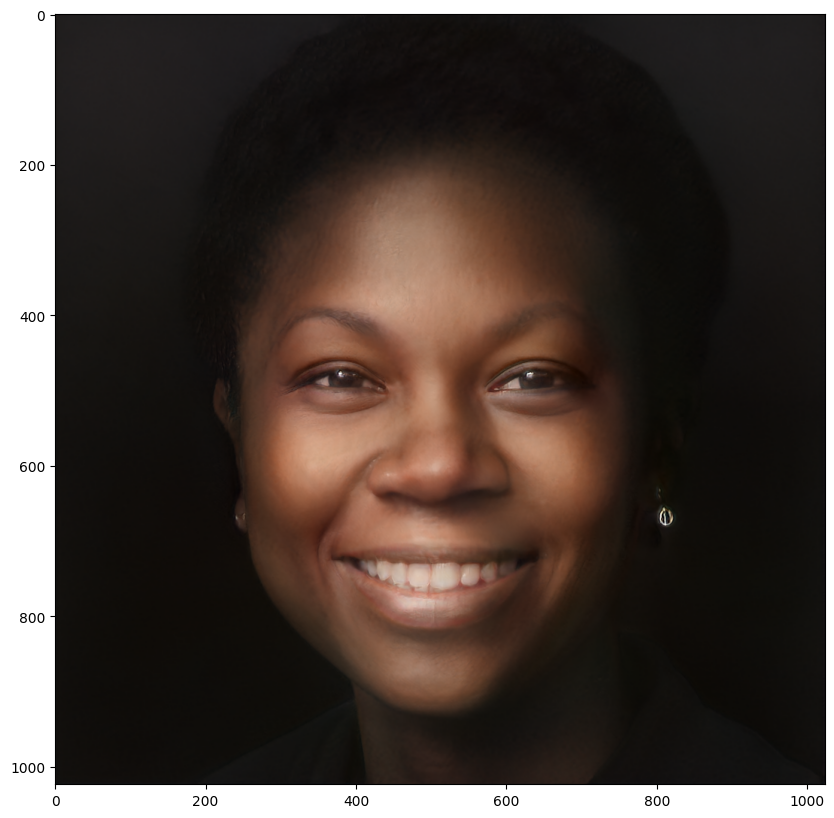

In [6]:
# загружаем изображение
inv_img_path = "../aligned_images/VGoldberg/0.jpg"
target_pil = PIL.Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

# инициализируем функции потерь 
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()
# arc_loss = Arcface_Loss(arcface_path, device)

# Параметры для оптимизации
num_steps = 150
seed = 42 
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32) 
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w_plus vector
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable


optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)

for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')
  
  lpips_loss_value = lpips_loss(synth_tensor, target_tensor)
  rec_loss_value = rec_loss(synth_tensor, target_tensor)

  loss = lpips_loss_value + rec_loss_value

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  

generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)
plot_image(generated_tensor)
print(loss.item())

In [7]:
torch.cuda.empty_cache()


### Encoder for editing

In [8]:
from stylegan2_models.e4e.model_utils import load_e4e_standalone
import torchvision.transforms as transforms


e4e_model, _ = load_e4e_standalone(path_to_e4e_model)
image2e4etensor = transforms.Compose([transforms.ToTensor(), 
                                transforms.Resize((256, 256)),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


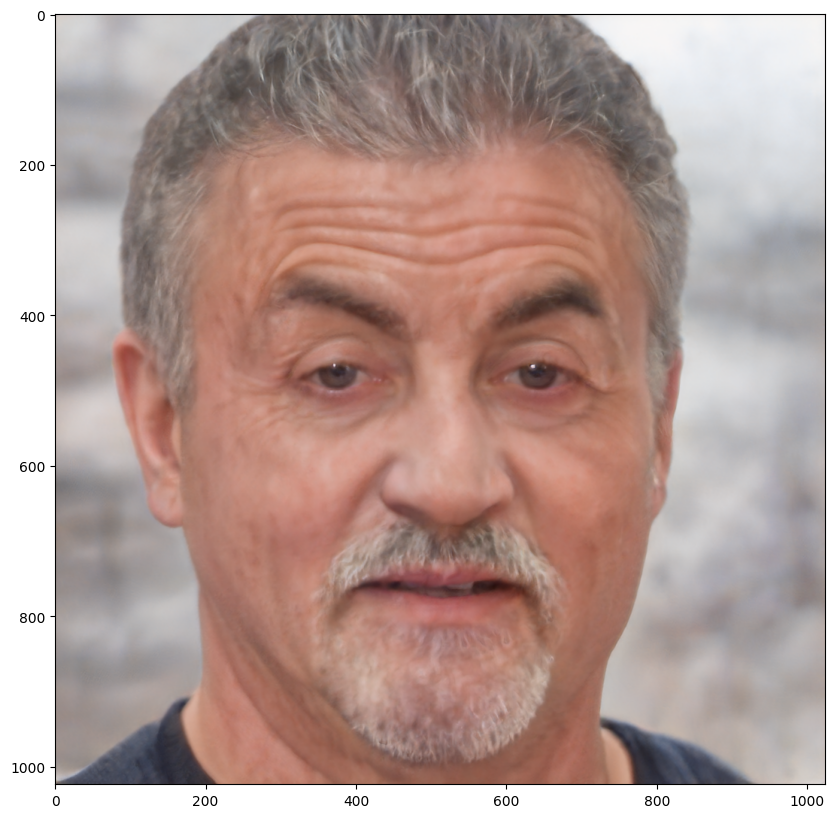

In [9]:
image_path = "../aligned_images/SStalone/0.jpg"
target_pil = Image.open(image_path).convert('RGB')
target_uint8 = np.array(target_pil, dtype=np.uint8)

e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
initial_latent_vector = e4e_model(e4e_tensor)
generated_tensor = G.synthesis(initial_latent_vector, noise_mode='const', force_fp32=True)
plot_image(generated_tensor)

### Save latent_vector images

In [11]:
images_path = ALIGNED_IMAGES_DIR
save_path = "../e4e_invertion"
count_images = 0
data = []
for persone in sorted(os.listdir(images_path)):
    person_images = os.path.join(images_path, persone)
    save_folder = os.path.join(save_path, persone)
    os.makedirs(save_folder, exist_ok=True)

    for image_name in os.listdir(person_images):
      image_path = os.path.join(person_images, image_name)

      target_pil = Image.open(image_path).convert('RGB')
      target_uint8 = np.array(target_pil, dtype=np.uint8)

      e4e_tensor = image2e4etensor(target_uint8).to(device).unsqueeze(0)
      
      latent_vector = e4e_model(e4e_tensor).detach().cpu()
      latent_path = os.path.join(save_folder, f"{image_name[:-3]}.pt")

      torch.save(latent_vector, latent_path)
      data.append([persone, image_name, image_path, latent_path])
      count_images += 1

# df = pd.DataFrame(data, columns = ['key', 'image_name', 'image_path', 'latent_path'])

## Interpolation and editing

In [24]:
latent1_filepath = "../e4e_invertion/SBurunov/0..pt"
latent2_filepath = "../e4e_invertion/JBlack/0..pt"
# latent2_filepath = "../editing/smile.pt"

def tensor_to_image(tensor):
    tensor = tensor.clone()
    tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
    img = img.resize((255,255))
    return img
    

def interpolate(latent1, latent2, psi=0.5, save=False):
    latent1 = latent1.clone()
    latent2 = latent2.clone()
    if save:
        latent1_img = tensor_to_image(G.synthesis(latent1, noise_mode='const', force_fp32=True))
        latent2_img = tensor_to_image(G.synthesis(latent2, noise_mode='const', force_fp32=True))
    # indeces = [5,6,7,8,9,10,11,12]
    indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    
    for i in indeces:
        latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
    
    generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
    
    if save:
        x_offset = 0
        generated_tensor_img = tensor_to_image(generated_tensor)
        new_im = Image.new('RGB', (255*3, 255))
        for im in [latent1_img, generated_tensor_img, latent2_img]:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
            new_im.save('result.jpg')
        
        
    plot_image(generated_tensor)
    
def interpolate_gif(latent2_orig, latent1_orig, step=0.05):
    imgs = []
    for psi in np.arange(0,1+step,step):
        latent1 = latent1_orig.clone()
        latent2 = latent2_orig.clone()
        # indeces = [5,6,7,8,9,10,11,12]
        indeces = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
        for i in indeces:
            latent1[:, i] = latent2[:, i].lerp(latent1[:, i], psi)
        
        generated_tensor = G.synthesis(latent1, noise_mode='const', force_fp32=True)
        img = tensor_to_image(generated_tensor)
        imgs.append(img)
    imgs[0].save(fp="result.gif", format="GIF", append_images=imgs[1:]+imgs[-1:1:-1], save_all=True, duration=100, loop=0)
        

    

latent1=torch.load(latent1_filepath).to(device)
latent2=torch.load(latent2_filepath).to(device)
interpolate_gif(latent1,latent2)
interactive(interpolate, latent1=fixed(latent1), latent2=fixed(latent2), 
            psi=widgets.FloatSlider(value=0.5, min=0, max=1.0, step=0.1))

#  Джоли-Вупи Голдберг, Стетхем - Сталоне, Бурунов - Джек блэк.


interactive(children=(FloatSlider(value=0.5, description='psi', max=1.0), Checkbox(value=False, description='s…